In [1]:
import numpy as np
import pandas as pd
import subprocess
from Bio import pairwise2
import tqdm
tlp = "/Users/john/data/deaminase/{}"
df = pd.read_json(tlp.format("index_af.json"),lines=True)
limit =10
sequences=[ s for s in df["uniprotSequence"].values][:limit]
accessions=[ s for s in df["uniprotAccession"].values][:limit]
# 初始化相似度矩阵
n = len(sequences)

def simseq(i, j):
    s1, s2 =sequences[i],sequences[j]
    alignments = pairwise2.align.globalxx(s1, s2)
    alignment = alignments[0]
    score = alignment[2]
    similarity = score / max(len(s1), len(s2))
    return similarity


def simpdb(i, j):
    pdb1 = tlp.format(f"pdbs/{accessions[i]}.pdb")
    pdb2 = tlp.format(f"pdbs/{accessions[j]}.pdb")
    cmd = ['TMalign', pdb1, pdb2]
    result = subprocess.run(cmd, capture_output=True, text=True)
    output = result.stdout
    for line in output.split('\n'):
        if 'TM-score=' in line and 'if normalized by length of Chain_2' in line:
            return line.strip().split()[1]
    return 0
    


similarity_matrix = np.zeros((n, n))

# 计算两两之间的相似度
for i in tqdm.tqdm(range(n)):
    for j in range(i, n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            similarity=simpdb(i,j)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

# 打印相似度矩阵

similarity_matrix

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


array([[1.     , 0.86744, 0.89914, 0.88656, 0.85863, 0.85728, 0.87781,
        0.89887, 0.86348, 0.98365],
       [0.86744, 1.     , 0.91256, 0.8944 , 0.95871, 0.8746 , 0.92835,
        0.96528, 0.91026, 0.93383],
       [0.89914, 0.91256, 1.     , 0.90208, 0.81574, 0.94055, 0.84341,
        0.86762, 0.80669, 0.87957],
       [0.88656, 0.8944 , 0.90208, 1.     , 0.81366, 0.89004, 0.85056,
        0.86241, 0.80903, 0.89106],
       [0.85863, 0.95871, 0.81574, 0.81366, 1.     , 0.86927, 0.92777,
        0.96052, 0.90839, 0.92757],
       [0.85728, 0.8746 , 0.94055, 0.89004, 0.86927, 1.     , 0.82908,
        0.86252, 0.79048, 0.85906],
       [0.87781, 0.92835, 0.84341, 0.85056, 0.92777, 0.82908, 1.     ,
        0.94097, 0.87607, 0.93022],
       [0.89887, 0.96528, 0.86762, 0.86241, 0.96052, 0.86252, 0.94097,
        1.     , 0.86196, 0.89794],
       [0.86348, 0.91026, 0.80669, 0.80903, 0.90839, 0.79048, 0.87607,
        0.86196, 1.     , 0.93249],
       [0.98365, 0.93383, 0.87957, 0.

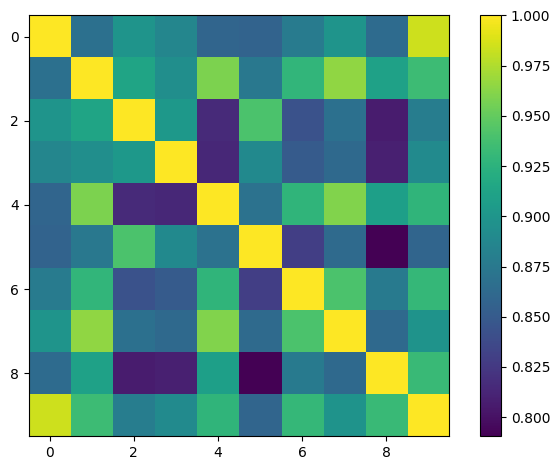

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(similarity_matrix)
plt.colorbar()
plt.tight_layout()
plt.show()

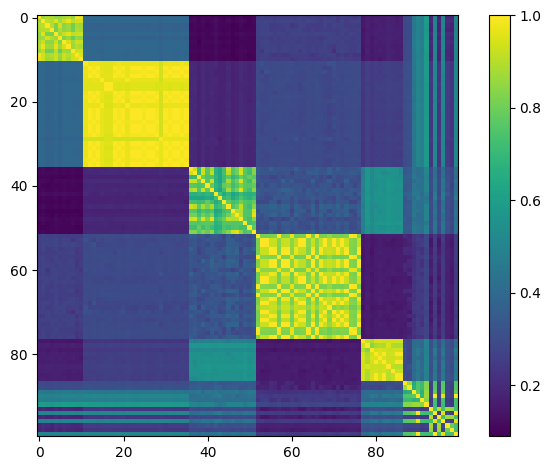

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(similarity_matrix)
plt.colorbar()
plt.tight_layout()
plt.show()

/var/folders/g3/9kgyg0z54nv7fpxy0pgwx0y80000gn/T/ipykernel_33469/700836823.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差


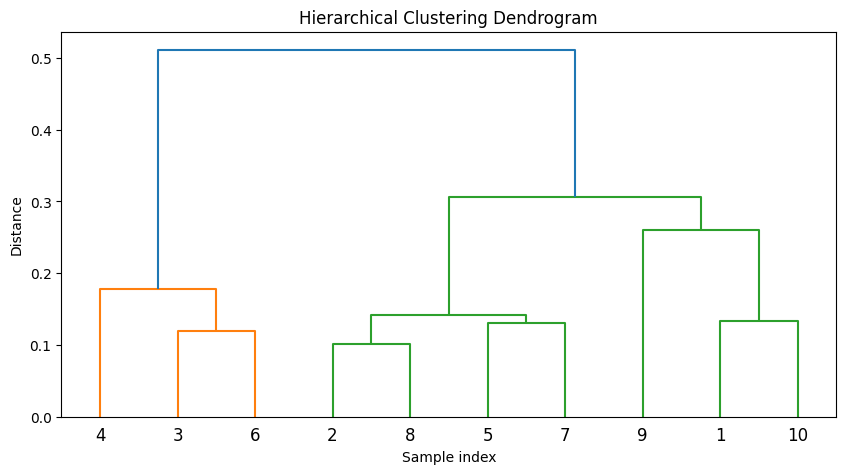

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 创建示例数据
distance_matrix = 1 - similarity_matrix
# 使用linkage函数进行层次聚类
Z = linkage(distance_matrix, method='ward')  # 'ward'方法最小化各簇内的方差

# 绘制树状图
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=np.arange(1, 11))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [25]:
import numpy as np
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist

# 转换为树结构
root_node, nodes = to_tree(Z, rd=True)


def get_newick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return f"{leaf_names[node.id]}:{parentdist - node.dist}{newick}"
    else:
        if len(newick) > 0:
            newick = f"): {parentdist - node.dist}{newick}"
        else:
            newick = ");"
        newick = get_newick(node.get_left(), newick, node.dist, leaf_names)
        newick = get_newick(node.get_right(), f",{newick}", node.dist, leaf_names)
        newick = f"({newick}"
        return newick

    
# 生成叶节点名称（假设数据点的索引为叶节点名称）
leaf_names = list(map(str, range(1, len(data) + 1)))

# 生成Newick格式字符串
newick_str = get_newick(root_node, "", root_node.dist, leaf_names)
print("Newick格式字符串:")
print(newick_str)
# 将Newick格式字符串保存到文件
with open("tree.nwk", "w") as file:
    file.write(newick_str)


Newick格式字符串:
((((10:0.13270816515949582,1:0.13270816515949582): 0.12707639680162866,9:0.2597845619611245): 0.045991069733252454,((7:0.13000088538160035,5:0.13000088538160035): 0.011632838356780528,(8:0.10183915946236011,2:0.10183915946236011): 0.039794564276020766): 0.16414190795599606): 0.20509615954282256,((6:0.11910932709070265,3:0.11910932709070265): 0.058234420661132796,4:0.17734374775183545): 0.333528043485364);


In [34]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace

tree = Tree(newick_str)
# 定义样式
def set_node_style(node):
    style = NodeStyle()
#     style["shape"] = "sphere"
    style["size"] = 10
    style["fgcolor"] = "darkred" if node.is_leaf() else "royalblue"
    style["vt_line_color"] = "black"
    style["hz_line_color"] = "black"
    style["vt_line_width"] = 2
    style["hz_line_width"] = 2
    style["vt_line_type"] = 0  # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    node.set_style(style)

for node in tree.traverse():
    set_node_style(node)
# 定义树的样式
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_scale = False
ts.branch_vertical_margin = 10
ts.mode = "c" # draw tree in circular mode

# 添加节点名称的样式
# for n in tree.traverse():
#     if n.is_leaf():
#         n.add_face(TextFace(n.name, fsize=10, fgcolor="darkred"), column=0, position="branch-right")

# 绘制并显示树
tree.show(tree_style=ts)